In [7]:
import pickle

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors

# Overview

The labels in this dataset are determined by a combination of positional and internal topological effects. In more depth, we come up with a scoring system that allows us to combine different metrics. *Positional effects* are determined by endowing each team with a pair of polar latent coordinates which map them into a 2-dimensional euclidean space. Radius and angle respectively determine the magnitude and sign of the positional score. *Topological effects* are determined by computing the gini index of the in-degree distribution of the nodes inside a subgraph. Teams' internal connectivity is generated according to two different patterns (associated to low and high gini) and the randomly rewired. In particular, these two connectivity patterns are **directed star** and **directed ring**. 

In [12]:
def directed_star(n_nodes, start_node = 0):  
    """Create star connectivity inside a subgraph/team."""
    G = nx.DiGraph()
    # Create star: all nodes are connected to a single node.
    G.add_node(start_node)
    G.add_edges_from([(i, start_node) for i in np.arange(start = start_node + 1, stop = start_node + n_nodes)])        
    return G

In [17]:
def directed_ring(n_nodes, start_node = 0):   
    """Create ring connectivity inside a subgraph/team."""
    G = nx.DiGraph()
    # Create ring.
    src = np.arange(n_nodes)
    dst = (np.arange(n_nodes)+1) % n_nodes
    G.add_edges_from(zip(src, dst))
    G = nx.convert_node_labels_to_integers(G, first_label = start_node)       
    return G

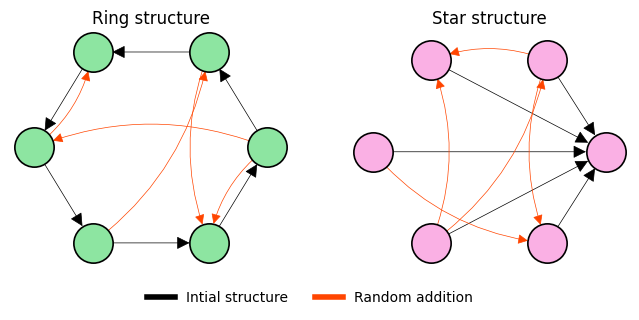

In [18]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 3))

# Ring.
G1 = directed_star(n_nodes = 6)
pos = nx.circular_layout(G1)
nx.draw_networkx_edges(G1, pos, edgelist = [(0,1),(1,2),(2,3),(3,4),(4,5),(5,0)], width = 0.5, 
                       arrowsize = 20, node_size = 800, ax = axs[0])
nx.draw_networkx_edges(G1, pos, edgelist = [(0,5),(1,5),(0,3),(3,2),(4,1)], width = 0.5, edge_color = "orangered",
                       connectionstyle = "arc3, rad = 0.2", arrowsize = 15, node_size = 800, ax = axs[0])
nodes = nx.draw_networkx_nodes(G1, pos, node_color = [sns.color_palette("pastel")[2]], linewidths = 1.2, node_size = 800, ax = axs[0])
nodes.set_edgecolor("k") # node border
axs[0].set_title("Ring structure")
axs[0].axis("off")

# Star.
G2 = directed_ring(n_nodes = 6)
pos = nx.layout.circular_layout(G2)
nx.draw_networkx_edges(G2, pos, edgelist = [(5,0),(4,0),(3,0),(2,0),(1,0)], width = 0.5, 
                       arrowsize = 20, node_size = 800, ax = axs[1])
nx.draw_networkx_edges(G2, pos, edgelist = [(1,2),(1,5),(3,5),(4,2),(4,1)], width = 0.5, edge_color = "orangered",
                       connectionstyle = "arc3, rad = 0.2", arrowsize = 15, node_size = 800, label="ciudades", ax = axs[1])
nodes = nx.draw_networkx_nodes(G2, pos, node_color = [sns.color_palette("pastel")[6]], linewidths = 1.2, node_size = 800, ax = axs[1])
nodes.set_edgecolor("k") # node border
axs[1].set_title("Star structure")
axs[1].axis("off")

legend_elements = [Line2D([0], [0], color = "k", label = "Intial structure", lw = 4),
                   Line2D([0], [0], color = "orangered", label = "Random addition", lw = 4)]
fig.legend(handles = legend_elements, loc = "lower center", bbox_to_anchor = (0.5, -0.07), 
           ncol = 2, frameon = False, fancybox = True, numpoints = 1)
    
fig.savefig("./data/topology_position.png", bbox_inches = "tight", dpi = 300)

# Graph

In [19]:
def random_add(G, ratio = 0.5): 
    """Add random edges inside the subgraph/team."""
    n_nodes = G.number_of_nodes()
    max_edges = n_nodes*(n_nodes-1)    
    n_edges_to_add = min(int(n_nodes*ratio), max_edges)
    
    nodes = list(G.nodes())
    
    # Add edges but not any self-loop.
    self_loop_check = True
    while self_loop_check:       
        src = np.random.choice(nodes, size = n_edges_to_add)
        dst = np.random.choice(nodes, size = n_edges_to_add)
        self_loop_check = not (src!=dst).all()
        
    G.add_edges_from(zip(src, dst))
    return G    

In [20]:
def gini(G):
    "Compute gini index of the in-degree distribution."
    array = pd.Series(dict(G.in_degree)).values
    array = array + 0.0000001
    array = np.sort(array) 
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]
    return (np.sum((2*index - n - 1) * array)) / (n*np.sum(array))

In [21]:
def circle_uniform(radius = 1):
    """Create coordinates into a circle of radius r."""
    r = radius * np.sqrt(np.random.random())
    theta = 2 * np.pi * np.random.random()
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

In [22]:
def cart2pol(x, y):
    """Get polar coordinates from cartesian coordinates."""
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi

In [23]:
def pol2cart(rho, phi):
    """Get cartesian coordinates from polar coordinates."""
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

In [24]:
def team_maker(n_teams = 100, min_team_size = 5, poisson_mean = 5, random_add_ratio = 0.5, wt = 0.5, wp = 0.5, seed = 0):   
    """
    Add motif structures to the various teams into the graph.

    :param n_team: number of teams to generate
    :param min_team_size: minimum team dimension
    :param poisson_mean: Poisson mean to add to provided minimum team size
    :param random_add_ratio: the ratio of edges to add randomly inside each team connectivity structure
    :param wt: the weight for the topology effect
    :param wp: the weight for the position effect
    :param seed: the random seed
    :return: 
    """    
    # Set random seed.
    np.random.seed(seed)
    
    graph_dict = {}
    comp_dict = {}
    coord_dict = {}
    
    scores_topology = []
    scores_position = []
    
    last_node_idx = 0    
    for team_id in range(n_teams):
        # Select team size.
        team_size = min_team_size
        team_size += np.random.poisson(poisson_mean)
        
        # Choice about the topology of the team.
        graph_type = np.random.choice(["ring", "star"])
       
        # Create subgraph/team.
        if graph_type == "star":       
            # Create team topology.
            G = directed_star(team_size, last_node_idx)
            # Add some random edge inside the base topology.
            G = random_add(G, random_add_ratio)
        elif graph_type == "ring":      
            # Create team topology.
            G = directed_ring(team_size, last_node_idx)
            # Add some random edge inside the base topology.
            G = random_add(G, random_add_ratio)
            
        last_node_idx += team_size
        
        # Create coordinates on a 2d space from a circle of radius 1.
        x_cart, y_cart = circle_uniform(radius = 1)
        # Get corresponding polar coordinates and sign.
        module, angle = cart2pol(x_cart, y_cart)
        sign = np.sign(np.cos(angle))

        # Compute scores topology and position.
        scores_topology.append(gini(G))
        scores_position.append(module*sign)
        # Store information.
        graph_dict[team_id] = G
        comp_dict[team_id] = list(G.nodes())
        coord_dict[team_id] = [x_cart, y_cart]

    # Standardization of the scores.
    scaler = StandardScaler()  
    scores = pd.DataFrame()
    scores["team_id"] = range(n_teams)
    scores["score_topology"] = scaler.fit_transform(np.array(scores_topology).reshape((-1,1)))
    scores["score_position"] = scaler.fit_transform(np.array(scores_position).reshape((-1,1)))
    scores["score"] = wt*scores["score_topology"] + wp*scores["score_position"]
    scores["score_discretized"] = pd.qcut(scores["score"], 3, labels = False)
    
    teams_label = scores["score_discretized"].to_dict()

    return graph_dict, comp_dict, coord_dict, scores, teams_label   

In [25]:
def team_connector(graph_dict, coord_dict, comp_dict, n_neighbors = 6, n_edges = 3):
    """Connect the nodes of the teams based on their position into the circle."""
    # Merge all the subgraphs into unique graph.
    G = nx.union_all(graph_dict.values())
    # Get the k nearest neighbors of each team.
    coord_matrix = np.array(list(coord_dict.values()))
    nneigh = NearestNeighbors(n_neighbors = n_neighbors, algorithm = "ball_tree")
    nneigh.fit(coord_matrix)
    
    nbrs = nneigh.kneighbors(coord_matrix, return_distance = False) 
    for team_id, graph in graph_dict.items():        
        for nbr in nbrs[team_id, 1:]:        
            src_nodes = comp_dict[team_id]
            dst_nodes = comp_dict[nbr]
        
            src = np.random.choice(src_nodes, size = n_edges)
            dst = np.random.choice(dst_nodes, size = n_edges)
        
            G.add_edges_from(zip(src, dst))
    return G    

In [26]:
graph_dict, comp_dict, coord_dict, scores, teams_label = team_maker(n_teams = 1000, random_add_ratio = 0.5, wt = 0.5, wp = 0.5)

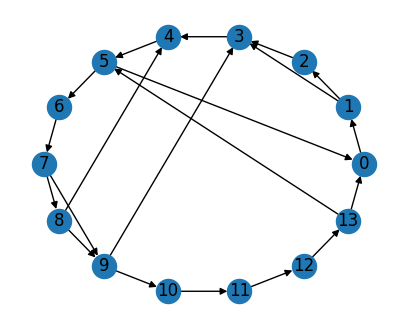

In [27]:
# Example.
fig, ax = plt.subplots(figsize = (5, 4))
nx.draw_circular(graph_dict[0], with_labels = True, ax = ax)

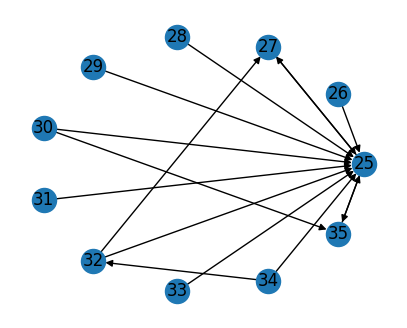

In [28]:
# Example.
fig, ax = plt.subplots(figsize = (5, 4))
nx.draw_circular(graph_dict[2], with_labels = True, ax = ax)

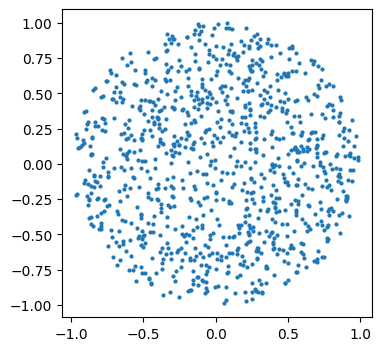

In [29]:
# Example: position coordinates.
fig, ax = plt.subplots(figsize = (4, 4))

x, y = zip(*list(coord_dict.values()))
ax.scatter(x, y, s = 4);

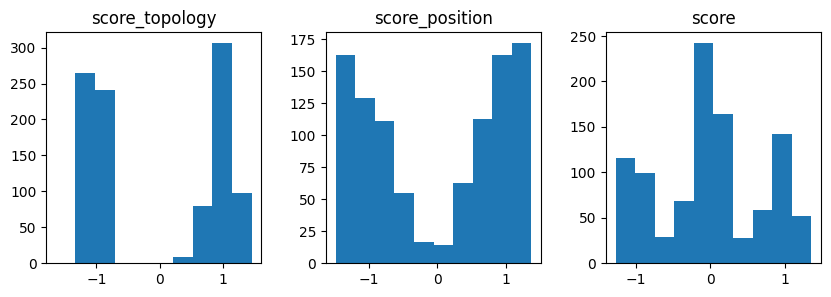

In [30]:
# Distributions.
scores[["score_topology", "score_position", "score"]].hist(figsize = (10, 3), layout = (1, 3), grid = False);

In [31]:
G = team_connector(graph_dict, coord_dict, comp_dict, n_edges = 3)

In [33]:
df = pd.DataFrame(comp_dict.items(), columns = ["team", "members"])
df.head()

,team,members
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]"
1,1,"[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"
2,2,"[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]"
3,3,"[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]"
4,4,"[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5..."


In [34]:
# Create team composition dictionary: {node_id: [team_id]}.
teams_composition = df.explode("members").groupby("members").apply(lambda x: list(x["team"])).to_dict()

In [35]:
# Add team attribute to each node.
nx.set_node_attributes(G, teams_composition, "Team")  

In [36]:
# Save Networkx graph.
with open("./data/graph.pkl", "wb") as f:
    pickle.dump(nx.readwrite.json_graph.node_link_data(G), f)

# Save teams label.
with open("./data/teams_label.pkl", "wb") as out:
    pickle.dump(teams_label, out)